In [1]:
import os
os.environ["OMP_NUM_THREADS"] = '32'
import numpy as np
import scipy.sparse as sp
import matplotlib.pyplot as plt
import math
import sys
sys.path.append('../')
from pyfd3d import pyfd3d
from pyMKL import pardisoSolver


In [34]:
L0 = 1e-6;  #length unit: microns
wvlen = 0.47;  # wavelength in L0


Npml = 1*np.array([10,10,10]);  # [Nx_pml Ny_pml]
xrange = 0.5*np.array([-1, 1]);  # x boundaries in L0
yrange = 0.5*np.array([-1, 1]);  # y boundaries in L0
zrange = 0.5*np.array([-1, 1]);
N = np.array([31,31,31])

In [35]:
## create domain with pml


In [36]:
## Set up the permittivity.
eps_r = np.ones(N)
print(eps_r.shape)
M = np.prod(N)
print(M)


(31, 31, 31)
29791


In [37]:
## Set up the current source density.
Jz = np.zeros(N);
ind_src = (np.ceil(N/2).astype('int'));  # (i,j) indices of the center cell; Nx, Ny should be odd
Jz[ind_src[0], ind_src[1], ind_src[2]] = 1;
Jx = np.zeros(N);
Jy = np.zeros(N);
eps_r_tensor_dict = {
    'eps_xx': eps_r,
    'eps_yy': eps_r,
    'eps_zz': eps_r,
}
JCurrentVector = {
    'Jx': Jx,
    'Jy': Jy,
    'Jz': Jz
}

In [38]:
## Wonsoek's scalar parameter 1, -1, or 0
s = -1;

In [39]:
dir(pyfd3d)

['__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__']

In [40]:
import pyfd3d.fd3d as fd3d

In [41]:
print(wvlen)

0.47


In [42]:
def createDws(w, f, dL, N):
    '''
        s = 'x' or 'y': x derivative or y derivative
        f = 'b' or 'f'
        catches exceptions if s and f are misspecified
    '''
    M = np.prod(N);
  

    sign = 1 if f == 'f' else -1;
    dw = None; #just an initialization
    indices = np.reshape(np.arange(M), N, order = 'F');
    if(w == 'x'):
        ind_adj = np.roll(indices, -sign, axis = 0)
        dw = dL[0]
    elif(w == 'y'):
        ind_adj = np.roll(indices, -sign, axis = 1)
        dw = dL[1];
    elif(w == 'z'):
        ind_adj = np.roll(indices, -sign, axis = 2)
        dw = dL[-1]
        
    # we could use flatten here since the indices are already in 'F' order
    indices_flatten = np.reshape(indices, (M, ), order = 'F')
    indices_adj_flatten = np.reshape(ind_adj, (M, ), order = 'F')
    # on_inds = np.hstack((indices.flatten(), indices.flatten()))
    # off_inds = np.concatenate((indices.flatten(), ind_adj.flatten()), axis = 0);
    on_inds = np.hstack((indices_flatten, indices_flatten));
    off_inds = np.concatenate((indices_flatten, indices_adj_flatten), axis = 0);

    all_inds = np.concatenate((np.expand_dims(on_inds, axis =1 ), np.expand_dims(off_inds, axis = 1)), axis = 1)

    data = np.concatenate((-sign*np.ones((M)), sign*np.ones((M))), axis = 0)
    Dws = sp.csc_matrix((data, (all_inds[:,0], all_inds[:,1])), shape = (M,M));

    return (1/dw)*Dws;

dL = [1,1,1]
Dxf = createDws('x', 'f', dL, N); 
Dyf = createDws('y', 'f', dL, N);
Dyb = createDws('y', 'b', dL, N); 
Dxb = createDws('x', 'b', dL, N); 
Dzf = createDws('z', 'f', dL, N); 
Dzb = createDws('z', 'b', dL, N); 

(5000.0, 0.0)

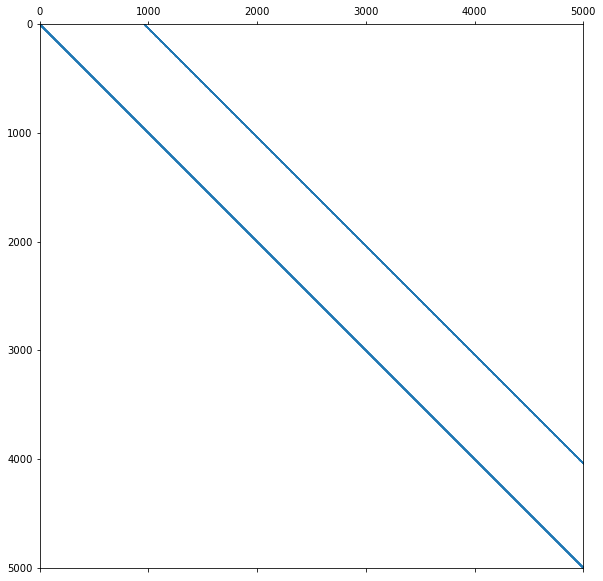

In [43]:
plt.figure(figsize = (10,10))
plt.spy(Dzf, markersize = 0.5)
plt.xlim(0,5000)
plt.ylim(5000,0)

In [55]:
A,b, Ch = fd3d.curlcurlE(L0, wvlen, xrange, yrange, zrange, eps_r_tensor_dict, JCurrentVector,Npml, symmetrize = 1)

(89373,)


  (0, 31)	(2923410231107.29-366914468683.9402j)
  (0, 0)	(-162646722968714.5+2966087548934.0625j)
  (0, 30)	(3463904121630.426-499460438053.08545j)
  (0, 1)	(3903291186768.174-568267368775.0496j)
  (1, 32)	(2923410231107.29-366914468683.9402j)
  (1, 1)	(-167430877830240.53+4060092169421.6875j)
  (1, 2)	(7248918175958.679-1456931518626.4736j)
  (1, 0)	(3903291186768.174-568267368775.0483j)
  (2, 33)	(2923410231107.29-366914468683.93994j)
  (2, 2)	(-177218162273668.3+7205061108333.484j)
  (2, 3)	(14266799707815.836-4134814856372.914j)
  (2, 1)	(7248918175958.68-1456931518626.4712j)
  (3, 34)	(2923410231107.29-366914468683.9402j)
  (3, 3)	(-198262254320078.94+17289005676603.719j)
  (3, 4)	(29545262961616.76-13155695825593.023j)
  (3, 2)	(14266799707815.836-4134814856372.923j)
  (4, 35)	(2923410231107.2905-366914468683.9404j)
  (4, 4)	(-243507613926701.38+53294928126424.56j)
  (4, 5)	(60763328831704.83-46490650391770.77j)
  (4, 3)	(29545262961616.766-13155695825593.025j)
  (5, 36)	(2923410

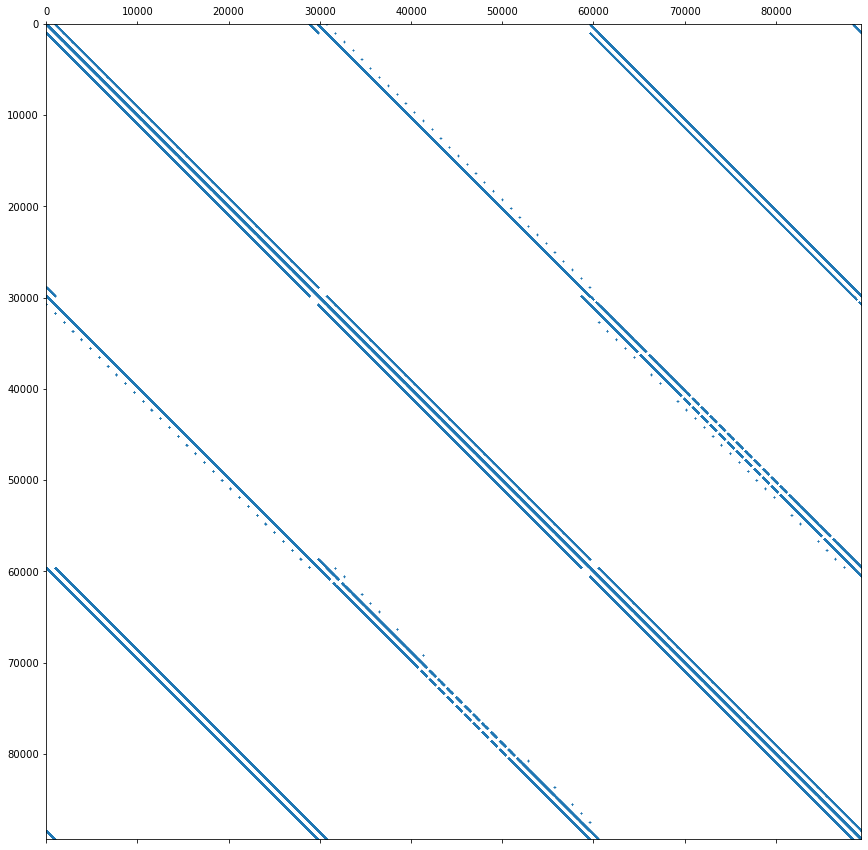

In [56]:
plt.figure(figsize = (15,15))
plt.spy(A, markersize = 0.2)
print(A[0:100, 0:100])

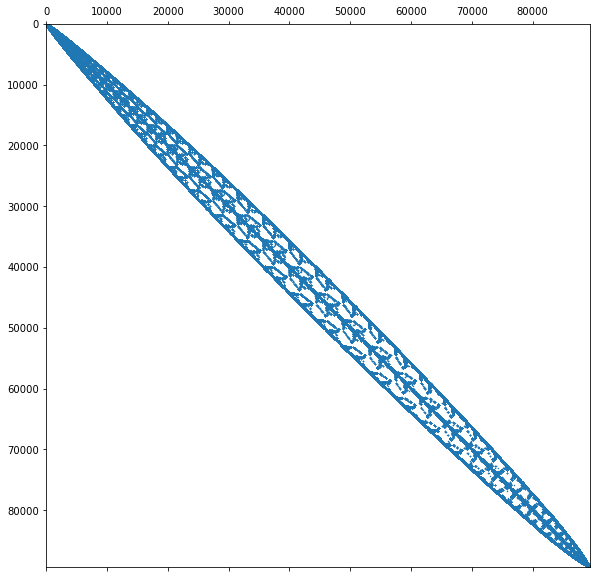

In [57]:
from scipy.sparse.csgraph import reverse_cuthill_mckee

prcm = reverse_cuthill_mckee(A)
row = np.arange(3*M)
col = prcm
P = sp.coo_matrix((np.ones(3*M), (row, col)), shape=(3*M,3*M))
plt.figure(figsize = (10,10))
plt.spy(P@A@P.T, markersize = 0.5)

## utilize iterative solver

In [58]:
from scipy.sparse.linalg import qmr, bicgstab

In [59]:
%%time
#x, info = qmr(A, b, maxiter = 2000)
x, info = bicgstab(A,b, maxiter = 2000);

CPU times: user 4.49 s, sys: 63.7 ms, total: 4.55 s
Wall time: 583 ms


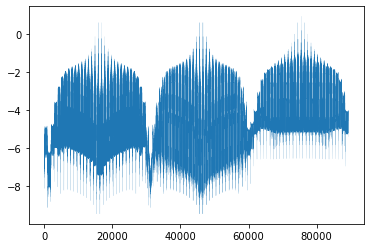

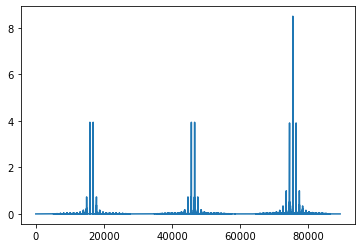

In [60]:
plt.figure();
plt.plot(np.log10(np.abs(x)), linewidth = 0.1)
plt.figure()
plt.plot(np.abs(x))

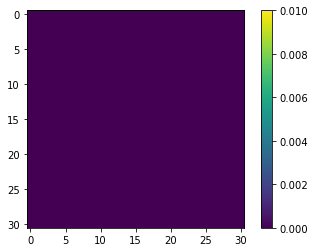

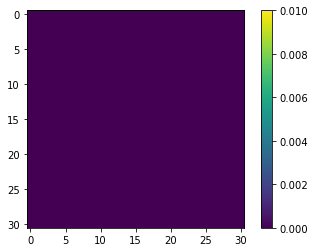

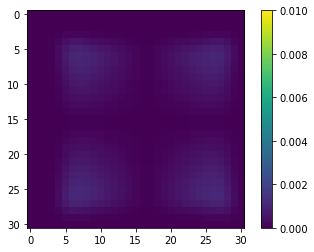

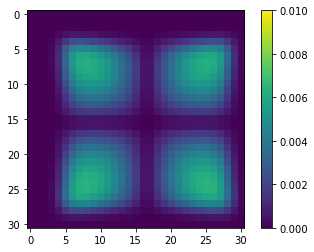

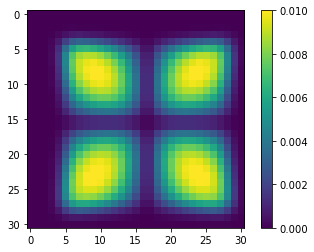

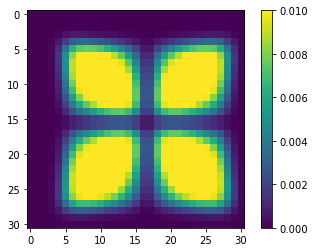

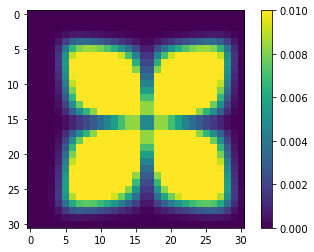

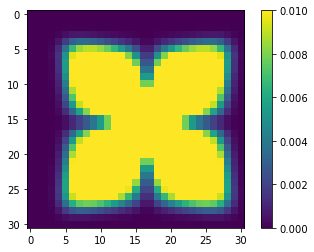

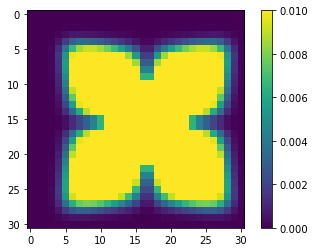

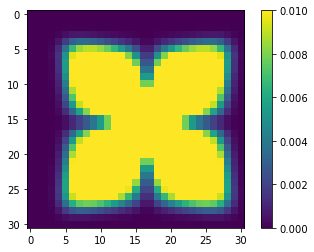

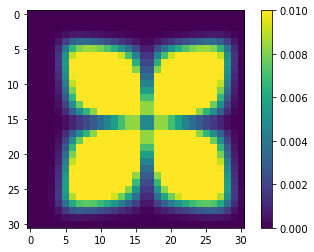

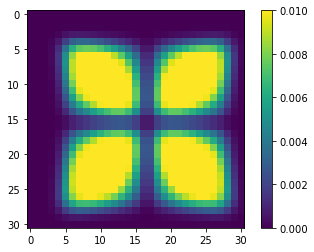

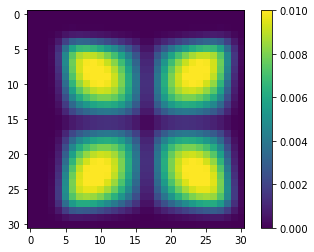

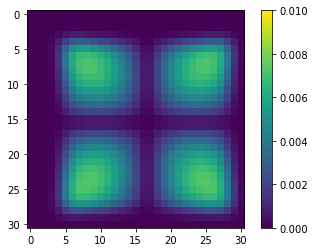

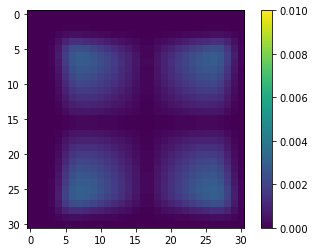

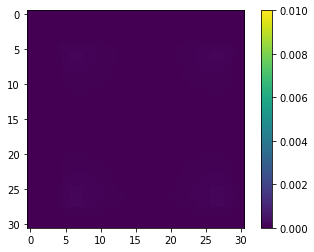

In [61]:
# flipped Ez looks like Ey, Ey looks like Ex, Ex looks like Ez
Ex = x[0:M].reshape(N, order = 'F');
Ey = x[M:2*M].reshape(N, order = 'F')
Ez = x[2*M:].reshape(N, order = 'F')

for i in range(0,N[0],2):
    plt.figure()
    plt.imshow(np.abs(Ex[:,i,:]))
    plt.clim(0,1e-2)
    plt.colorbar()



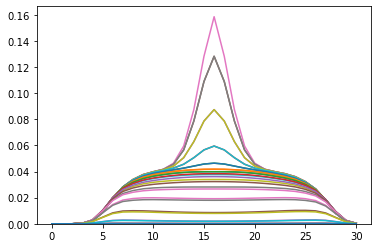

In [63]:

plt.figure();
for i in range(N[0]):
    plt.plot(np.abs(Ez[i,:,12]))
plt.ylim(ymin = 0)
plt.show()

In [64]:
print(A.shape)

(89373, 89373)


## WARNING: careful with direct solvers

In [74]:
#try solving with pardiso
# pardiso doesn't even really work with this FDFD matrix, which is odd...honestly very very odd

## for vaccum, mtype=13, complex, non-symmetric
# mtype=6 is complex symmetric
pSolve = pardisoSolver(A, mtype=6)



In [81]:
A.shape

print(A.count_nonzero())

1171707


In [75]:
%%time
pSolve.factor()


CPU times: user 2min 45s, sys: 1.54 s, total: 2min 46s
Wall time: 21 s


In [76]:
print(pSolve.iparm)

[       1        3        0        0        0        0        0        0
        0        8        0        0        0        0    65467    64262
  1595319 97766390       -1        0        1        0        0        1
        0        0        0        0        0        0        0        0
        0        0        1        0        0        0        0        0
        0        0        0        0        0        0        0        0
        0        0        0        0        0        0        0        0
        0        0        0        0        0        0   132172        0]


In [77]:
# use unsymmetric case
pSolve = pardisoSolver(A, mtype=13)

In [78]:
%%time
pSolve.factor()


CPU times: user 2min 5s, sys: 5.2 s, total: 2min 10s
Wall time: 17.8 s


In [79]:
print(pSolve.iparm)

[        1         3         8         0         0         0         0
         0         0        13         1         0         1         0
    127243     93180   2548046 154265493   2140450         0         0
         0         0         1         0         0         0         0
         0         0         0         0         0        -1         1
         0         0         0         0         0         0         0
         0         0         0         0         0         0         0
         0         0         0         0         0         0         0
        -1         0         0         0    127243    186937    126783
         0]


In [22]:
# x0 = pSolve.solve(np.imag(b))
# plt.plot(np.abs(x0))
# plt.figure()
# Ex = np.reshape(x0[0:M],N)

# plt.imshow(np.abs(Ex[:,:,0]))

In [23]:
# plt.figure(figsize = (10,5))
# plt.plot(np.abs(x0))
# plt.plot(np.abs(x), 'x-', markersize = 1, alpha = 0.2)

## check pml

In [24]:
#Syfi, Sxfi, Sybi, Sxbi, Szfi, Szbi = S_create_3D(omega, dL, N, Npml, eps0, eta0) #sp.identity(M);
